 # Seattle Temperature Forecast
Using deep learning (LSTM Neural Net) to predict future temperature minimums in seattle based on existing trends

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import lightning as pl
from lightning.pytorch.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler #
from sklearn.model_selection import train_test_split

## Part 1: Exploratory Data Analysis

In [3]:
weather_data = pd.read_csv('/Users/llukii/Downloads/seattle-weather.csv')

In [4]:
weather_data.shape

(1461, 6)

In [5]:
weather_data.head(5)

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [6]:
weather_data.tail(5)

,date,precipitation,temp_max,temp_min,wind,weather
1456,2015-12-27,8.6,4.4,1.7,2.9,rain
1457,2015-12-28,1.5,5.0,1.7,1.3,rain
1458,2015-12-29,0.0,7.2,0.6,2.6,fog
1459,2015-12-30,0.0,5.6,-1.0,3.4,sun
1460,2015-12-31,0.0,5.6,-2.1,3.5,sun


In [7]:
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [8]:
weather_data.describe()

,precipitation,temp_max,temp_min,wind
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,3.029432,16.439083,8.234771,3.241136
std,6.680194,7.349758,5.023004,1.437825
min,0.000000,-1.600000,-7.100000,0.400000
25%,0.000000,10.600000,4.400000,2.200000
50%,0.000000,15.600000,8.300000,3.000000
75%,2.800000,22.200000,12.200000,4.000000
max,55.900000,35.600000,18.300000,9.500000


In [9]:
# Since we want to solely analyze numerical data, drop the weather column and set the index to date.
weather_data.set_index('date', inplace=True)
weather_data.drop('weather', axis=1, inplace=True)
weather_data

,precipitation,temp_max,temp_min,wind
date,,,,
2012-01-01,0.0,12.8,5.0,4.7
2012-01-02,10.9,10.6,2.8,4.5
2012-01-03,0.8,11.7,7.2,2.3
2012-01-04,20.3,12.2,5.6,4.7
2012-01-05,1.3,8.9,2.8,6.1
...,...,...,...,...
2015-12-27,8.6,4.4,1.7,2.9
2015-12-28,1.5,5.0,1.7,1.3
2015-12-29,0.0,7.2,0.6,2.6


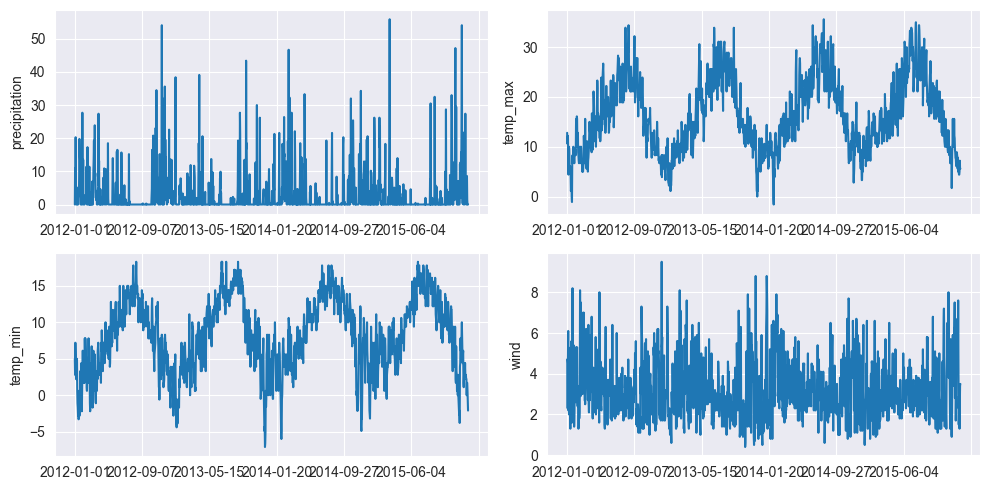

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,5))
for i, col in enumerate(weather_data.columns):
    if i == 4: break
    plt.subplot(2, 2, i+1)
    weather_data[col].plot()
    plt.xlabel(None)
    plt.ylabel(col)

fig.tight_layout()

<Axes: title={'center': 'Minimum temperature distribution in seattle from 2012-2015'}, xlabel='Min temp (ºC)', ylabel='Frequency'>

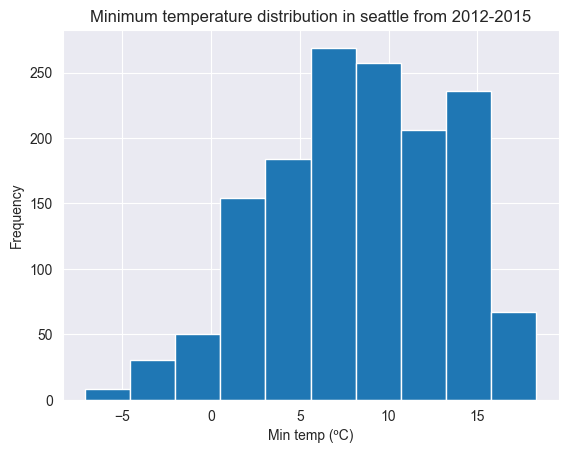

In [11]:
weather_data['temp_min'].plot(kind='hist',
                              title="Minimum temperature distribution in seattle from 2012-2015",
                              xlabel='Min temp (ºC)')

<Axes: title={'center': 'Min temperature (ºC)'}, ylabel='Density'>

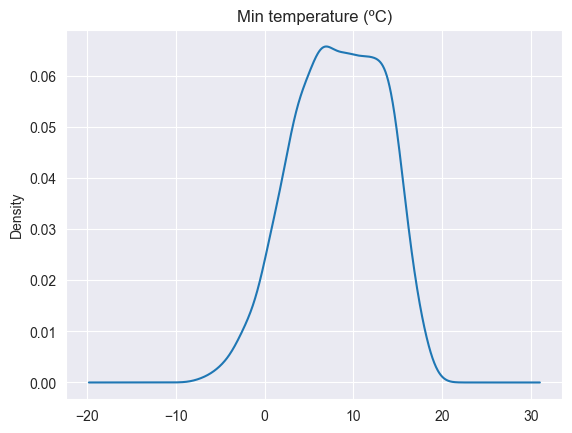

In [12]:
weather_data['temp_min'].plot(
    kind='kde',
    title="Min temperature (ºC)"
)

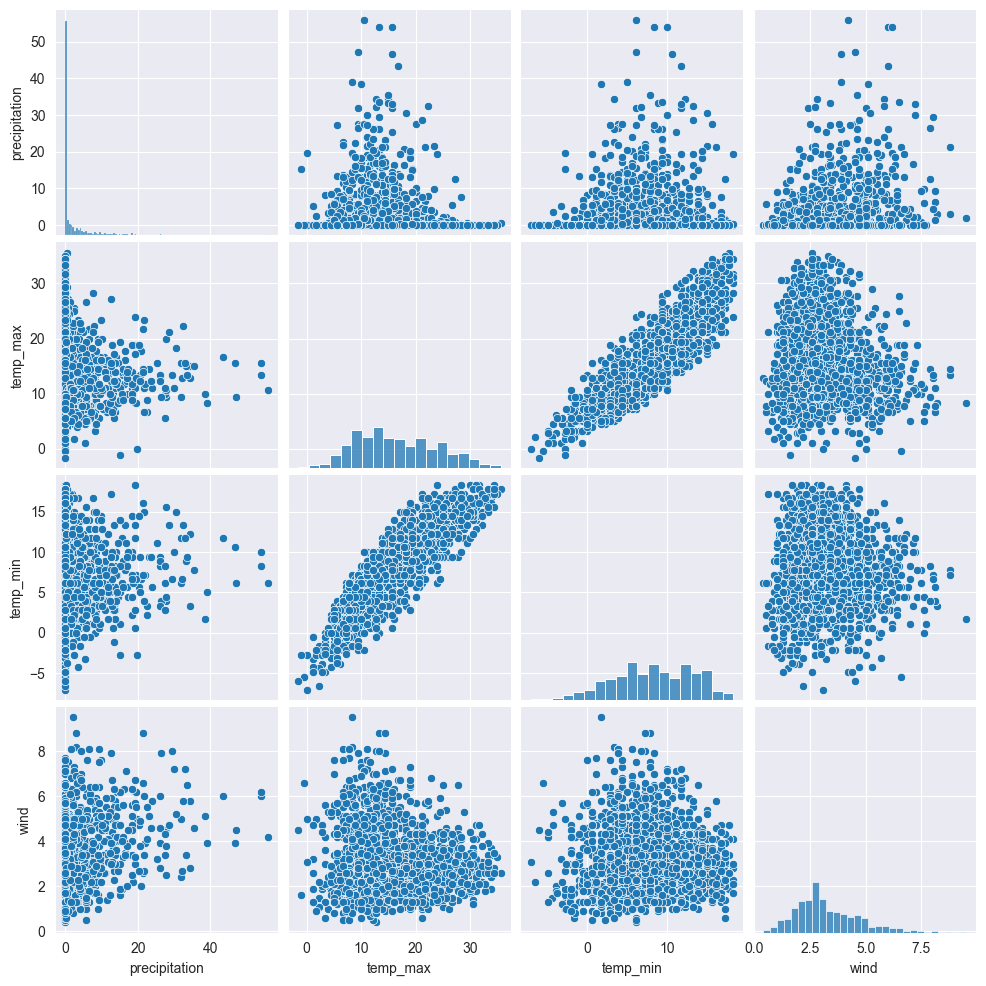

In [13]:
sns.pairplot(weather_data)

## Preparing for training

In [14]:
scalar = MinMaxScaler()
scalar.fit(weather_data)
weather_normalized = scalar.transform(weather_data)
sequence_length = 28 # consider temperature change from last two weeks

pred_x, pred_y = [], []
for idx in range(sequence_length, weather_data.shape[0]):
    # Temperature minimum
    pred_x.append(weather_normalized[idx-sequence_length:idx, 2])
    pred_y.append(weather_data.iloc[idx, 2])

pred_x = np.array(pred_x, dtype=np.float32).reshape(-1, sequence_length, 1)
pred_y = np.array(pred_y, dtype=np.float32)
train_x, test_x, train_y, test_y = train_test_split(pred_x, pred_y, test_size=0.2)
test_x, val_x, test_y, val_y = train_test_split(test_x, test_y, test_size=0.5)

In [15]:
batch_size = 64
class Weather(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

device = torch.device('mps' if torch.mps.is_available() else 'cpu')
train_loader = DataLoader(Weather(train_x, train_y), batch_size=batch_size)
val_loader = DataLoader(Weather(val_x, val_y), batch_size=batch_size)
test_loader = DataLoader(Weather(test_x, test_y), batch_size=batch_size)

### Neural Network
Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. Neural Computation, 9(8), 1735–1780. https://doi.org/10.1162/neco.1997.9.8.1735

In [21]:
class NeuralNet(pl.LightningModule):
    def __init__(self):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=256,
            batch_first=True,
            dropout=0.5
        )
        self.dropout = nn.Dropout(0.2)
        self.linear = nn.Sequential(
            nn.Linear(256, 32),
            nn.ReLU(),
            nn.BatchNorm1d(32),
            nn.Linear(32, 1)
        )
        self.loss_graph = []

    def forward(self, x):
        _, (x, _) = self.lstm(x)
        x = self.dropout(x[-1])
        x = self.linear(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.mse_loss(y_hat.reshape(-1), y)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx)
        self.log('val_loss', loss)
        self.loss_graph.append(loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self.training_step(batch, batch_idx)
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)


In [22]:
model = NeuralNet()
num_epochs = 40
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
trainer = pl.Trainer(max_epochs=num_epochs, accelerator='mps',
                     callbacks=[early_stopping], gradient_clip_val=0.5)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params | Mode 
-----------------------------------------------
0 | lstm    | LSTM       | 265 K  | train
1 | dropout | Dropout    | 0      | train
2 | linear  | Sequential | 8.3 K  | train
-----------------------------------------------
273 K     Trainable params
0         Non-trainable params
273 K     Total params
1.094     Total estimated model params 

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (18) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 0: 100%|██████████| 18/18 [00:00<00:00, 27.70it/s, v_num=0]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██████████| 18/18 [00:00<00:00, 102.65it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████| 18/18 [00:00<00:00, 107.67it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██████████| 18/18 [00:00<00:00, 107.26it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██████████| 18/18 [00:00<00:00, 108.38it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██████████| 18/18 [00:00<00:00, 108.89it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██████████| 18/18 [00:00<00:00, 107.98it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|██████████| 18/18 [00:00<00:00, 107.32it/s, v_num=0]     
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|██████████| 18/18 [00:00<00:00, 109.86it/s, v_nu

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 18/18 [00:00<00:00, 91.46it/s, v_num=0]


## Evaluate Model Performance

Text(0, 0.5, 'Loss')

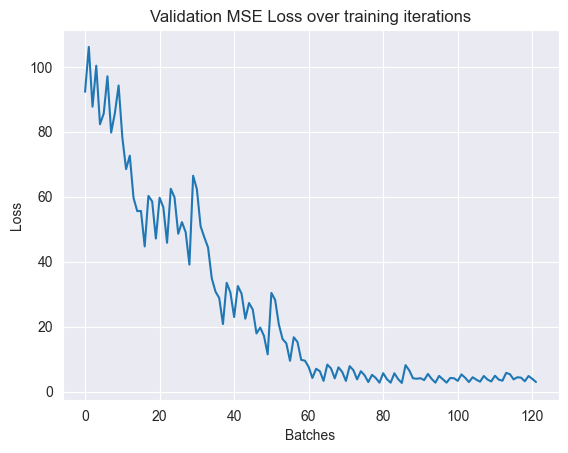

In [23]:
sns.lineplot(torch.tensor(model.loss_graph).detach().numpy())
plt.title("Validation MSE Loss over training iterations")
plt.xlabel("Batches")
plt.ylabel("Loss")

In [24]:
trainer.test(model, dataloaders=test_loader)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 3/3 [00:00<00:00, 32.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     3.581130266189575     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 3.581130266189575}]

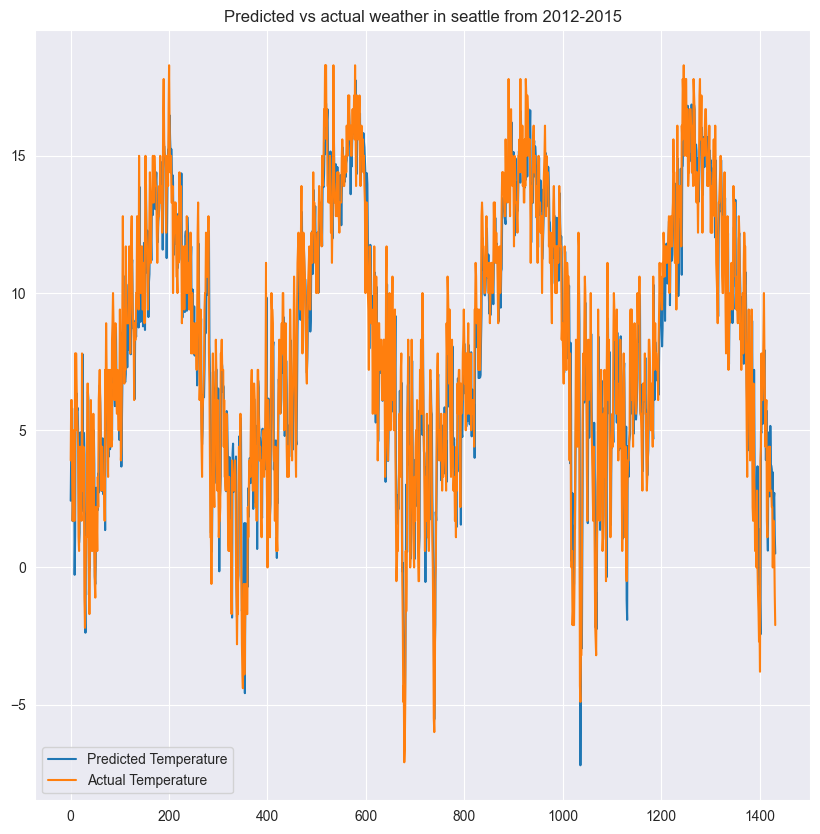

In [25]:
model_pred = model(torch.tensor(pred_x, dtype=torch.float32))
model_pred = model_pred.detach().cpu().numpy()
# model_pred
plt.figure(figsize=(10, 10))
plt.title("Predicted vs actual weather in seattle from 2012-2015")
plt.plot(model_pred, label="Predicted Temperature")
plt.plot(pred_y, label="Actual Temperature")
plt.legend()